# Rutinas para generación de insumos de límites flexibles y otros - Humedad relativa

> Elaborado por Paola Álvarez, profesional contratista IDEAM, contrato 196 de 2024. Comentarios o inquietudes, remitir a *palvarez@ideam.gov.co* 

**Librerías**

In [76]:
import pandas as pd
import numpy as np
import datetime
import statistics
import glob
import os
import csv
import re
import xarray as xr
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.chart import ScatterChart, Series, Reference
from openpyxl.utils.dataframe import dataframe_to_rows
#from openpyxl.chart.layout import Layout, ManualLayout
from collections import deque
from datetime import timedelta
from scipy import stats

____

### Se exportan coordenadas de HR

In [2]:
try:

    'hola'+ 5

except ValueError:

    print('Error 1')

except TypeError:

    print('Error 2')

except:

    print('Error 3')

Error 2


In [3]:
# Ruta a la carpeta con los archivos
carpeta = 'RawUnmodified_HR'

# Si la carpeta no existe, imprimir un mensaje
if not os.path.exists(carpeta):
    print(f"La carpeta '{carpeta}' no existe. Por favor, verifica la ruta.")

# Obtener la lista de todos los archivos en la carpeta
todos_los_archivos = os.listdir(carpeta)

# Filtrar los archivos que sigan el patrón 'Estacion_XXXXXXXXX.csv'
archivos = [f for f in todos_los_archivos if f.startswith('Estacion_') and len(f) == 23 and f[9:19].isdigit() and f.endswith('.csv')]

# Extraer los 10 últimos dígitos de cada nombre de archivo
componentes_numericos = [f[9:19] for f in archivos]

# Imprimir la lista resultante
print(componentes_numericos)

['0011025501', '0011030010', '0011035030', '0011045010', '0011050020', '0011080010', '0011105020', '0011115020', '0011115501', '0011120040', '0011135030', '0011155030', '0011159010', '0011175000', '0012015060', '0012015100', '0012015110', '0012025040', '0012045020', '0013035501', '0013055040', '0013085030', '0013085050', '0013095010', '0014015010', '0014015020', '0014015080', '0014017001', '0015015050', '0015015060', '0015015100', '0015015120', '0015035020', '0015065040', '0015065180', '0015065190', '0015065501', '0015075150', '0015075501', '0015079010', '0015085030', '0015085050', '0016015110', '0016015120', '0016015130', '0016015501', '0016015502', '0016025040', '0016025501', '0016025502', '0016025503', '0016035010', '0016035030', '0016035501', '0016040050', '0016055120', '0016055501', '0017015010', '0017017001', '0017025020', '0017035010', '0021015030', '0021015040', '0021015050', '0021015060', '0021015070', '0021015501', '0021015502', '0021025030', '0021035040', '0021035501', '0021

In [4]:
EMAHRcod = pd.DataFrame(componentes_numericos,columns=['Station'])
EMAHRcod

,Station
0,0011025501
1,0011030010
2,0011035030
3,0011045010
4,0011050020
...,...
615,5205500123
616,5311500056
617,5311500121
618,5311500147


In [5]:
EMAHRcod['Station'] = EMAHRcod['Station'].astype('int64')

In [6]:
EMAHRcod.dtypes

Station    int64
dtype: object

In [7]:
#dfsttnallinfo = pd.read_csv('stations_all.csv')
#dfsttnallinfo
CNE_All = pd.read_excel('../1_PresionAtmosferica/CNE_All_2024_07.xlsx')

In [8]:
CNE_All.rename(columns={'CODIGO':'Station','LATITUD':'lat','LONGITUD':'long', 'ENTIDAD':'entidad'}, inplace=True)

In [9]:
# Se unen ambos dataframe para obtener la información de coordenadas
dfsttninfo_EMAHR_Lctn = pd.merge(EMAHRcod, CNE_All[['Station','lat','long','entidad']], on='Station', how='left')
dfsttninfo_EMAHR_Lctn

,Station,lat,long,entidad
0,11025501,5.888719,-76.145167,CENTRO NACIONAL DE INVESTIGACIONES DE CAFE
1,11030010,5.380000,-76.610000,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...
2,11035030,5.284828,-76.627822,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...
3,11045010,5.690556,-76.643778,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...
4,11050020,5.994722,-76.780028,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...
...,...,...,...,...
615,5205500123,1.054806,-77.270250,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...
616,5311500056,3.848308,-76.987017,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...
617,5311500121,3.645194,-76.564750,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...
618,5311500147,3.890083,-77.070331,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...


In [10]:
dfsttninfo_EMAHR_Lctn.shape

(620, 4)

In [11]:
dfsttninfo_EMAHR_Lctn.head(2)

,Station,lat,long,entidad
0,11025501,5.888719,-76.145167,CENTRO NACIONAL DE INVESTIGACIONES DE CAFE
1,11030010,5.380000,-76.610000,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...


In [12]:
dfsttninfo_EMAHR_Lctn[dfsttninfo_EMAHR_Lctn.duplicated(subset=['Station'])]

,Station,lat,long,entidad


In [25]:
filtro = dfsttninfo_EMAHR_Lctn['lat'].isna()

In [26]:
dfsttninfo_EMAHR_Lctn[filtro]

,lat,long,entidad
Station,,,


In [16]:
dfsttnallinfo.set_index('Station', inplace=True)

In [22]:
dfsttninfo_EMAHR_Lctn.set_index('Station',inplace=True)

In [23]:
dfsttnallinfo_sbst = dfsttnallinfo[['lat', 'long']]
dfsttninfo_EMAHR_Lctn[['lat', 'long']] = dfsttninfo_EMAHR_Lctn[['lat', 'long']].fillna(dfsttnallinfo_sbst)

In [24]:
dfsttninfo_EMAHR_Lctn[dfsttninfo_EMAHR_Lctn.duplicated()]

,lat,long,entidad
Station,,,
21205514,4.469316,-74.079454,CAR - CORPORACION AUTONOMA REGIONAL DE CUNDINA...
21205523,4.788157,-74.050059,CAR - CORPORACION AUTONOMA REGIONAL DE CUNDINA...
21206790,5.090500,-73.881250,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...
25025350,9.316389,-75.387500,INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...


In [27]:
dfsttninfo_EMAHR_Lctn.reset_index(inplace=True)

In [ ]:
dfsttninfo_EMAHR_Lctn[filtro]

In [29]:
dfsttninfo_EMAHR_Lctn.shape

(620, 4)

In [30]:
dfsttninfo_EMAHR_Lctn.to_excel('EMA_HR_coord.xlsx')

____ 

## Unir coords, freq, Ent con alturas y regiones

In [2]:
freqInstData = pd.read_csv('EMAHR_LatLonEntFreq2.csv', encoding='latin-1')

In [26]:
freqInstData['entidad'].unique()

array(['CENTRO NACIONAL DE INVESTIGACIONES DE CAFE', 'IDEAM', 'INVEMAR',
       'INSTITUTO DE INVESTIGACIONES MARINAS Y COSTERAS JOSE BENITO VIVES DE ANDREIS',
       'CAR - CORPORACION AUTONOMA REGIONAL DE CUNDINAMARCA',
       'FONDO DE PREVENCION Y ATENCION DE DESASTRES DE BOGOTA DC - FOPAE',
       'ESTACIONES PARTICULARES',
       'EMPRESA DE ACUEDUCTO Y ALCANTARILLADO DE BOGOTA E.S.P',
       'ISAGEN  S.A. E.S.P', 'CORPORACION REGIONAL DEL QUINDIO',
       'INSTITUTO DISTRITAL DE GESTIÓN DE RIESGOS Y CAMBIO CLIMÁTICO'],
      dtype=object)

In [22]:
AltRegs= pd.read_table('EMAHR_GeoInfo_Replaceable.txt', encoding='latin-1', sep=';')

In [4]:
freqInstData.head(2)

,Unnamed: 0,Station,lat,long,entidad,FreqInf
0,0,11025501,5.888719,-76.145167,CENTRO NACIONAL DE INVESTIGACIONES DE CAFE,5T
1,1,11030010,5.380000,-76.610000,IDEAM,H


In [23]:
AltRegs['RegsNat'].unique()

array(['Andina', 'PacÃ\xadfico', 'Caribe', 'OrinoquÃ\xada',
       'AmazonÃ\xada', 'Insular'], dtype=object)

In [19]:
AltRegs.head(3)

,OBJECTID,F1,Station,lat,long_,entidad,RASTERVALU,RegsNat
0,1,0,11025501,5.888719,-76.145167,CENTRO NACIONAL DE INVESTIGACIONES DE CAFE,1649,Andina
1,2,1,11030010,5.380000,-76.610000,IDEAM,92,Pacífico
2,3,2,11035030,5.284828,-76.627822,IDEAM,102,Pacífico


In [20]:
dfMoreInfo = pd.merge(freqInstData, AltRegs[['Station','RASTERVALU','RegsNat']], on='Station', how='left')
dfMoreInfo.head(2)

,Unnamed: 0,Station,lat,long,entidad,FreqInf,RASTERVALU,RegsNat
0,0,11025501,5.888719,-76.145167,CENTRO NACIONAL DE INVESTIGACIONES DE CAFE,5T,1649.0,Andina
1,1,11030010,5.380000,-76.610000,IDEAM,H,92.0,Pacífico


In [27]:
dfMoreInfo.to_csv('EMAHR_Allinfo_Replcbl.csv', index=False,encoding='latin-1')

______

## Cálculo de límites por región natural

In [34]:
import os
import pandas as pd
import gc

def obtener_EstadDescript(archivo):
    try:
        datos = pd.read_csv(archivo, encoding='latin-1', dtype={'Valor': 'float32'})
        datos['Fecha'] = pd.to_datetime(datos['Fecha'], errors='coerce')
        datos = datos[(datos['Valor'] >= 0.0) & (datos['Valor'] <= 100.0)]

        station = datos['Station'].values[0]
        stats = {
            'minimo': datos['Valor'].min(),
            'maximo': datos['Valor'].max(),
            'media': datos['Valor'].mean(),
            'mediana': datos['Valor'].median(),
            'desvest': datos['Valor'].std(),
            'varianza': datos['Valor'].var(),
            'percentil_97': datos['Valor'].quantile(0.97),
            'percentil_3': datos['Valor'].quantile(0.03)
        }

        return station, datos['Valor'], stats
    
    except Exception as e:
        print(f"Error con el archivo {archivo}: {e}")
        return None, None, {}

def procesar_lote(archivos, referencia_df, ruta_carpeta):
    datos_por_region = {}

    for archivo in archivos:
        ruta_archivo = os.path.join(ruta_carpeta, archivo)
        station, valores, stats = obtener_EstadDescript(ruta_archivo)

        if station and valores is not None:
            regnat_match = referencia_df.loc[referencia_df['Station'] == station, 'RegsNat']
            if not regnat_match.empty:
                regnat = regnat_match.values[0]
                if regnat not in datos_por_region:
                    datos_por_region[regnat] = {
                        'Valor': [],
                        'stations': set(),
                        'minimo': [],
                        'maximo': [],
                        'media': [],
                        'mediana': [],
                        'desvest': [],
                        'varianza': [],
                        'percentil_97': [],
                        'percentil_3': []
                    }
                datos_por_region[regnat]['Valor'].extend(valores.tolist())
                datos_por_region[regnat]['stations'].add(str(station))
                for key, value in stats.items():
                    datos_por_region[regnat][key].append(value)
    
    gc.collect()  # Liberar memoria
    return datos_por_region

def main():
    ruta_carpeta = 'RawUnmodified_HR'
    ruta_referencia = 'EMAHR_Allinfo_Replcbl.csv'

    referencia_df = pd.read_csv(ruta_referencia, encoding='latin-1')
    archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.csv')]
    
    resultados_por_region = []
    lote_size = 50  # Tamaño del lote, ajustar según sea necesario

    for i in range(0, len(archivos), lote_size):
        lote_archivos = archivos[i:i + lote_size]
        datos_por_region = procesar_lote(lote_archivos, referencia_df, ruta_carpeta)

        for regnat, datos in datos_por_region.items():
            valores_series = pd.Series(datos['Valor'])
            percentil_97_region = valores_series.quantile(0.97)
            percentil_3_region = valores_series.quantile(0.03)
            resultados_por_region.append([
                regnat,
                percentil_97_region,
                percentil_3_region,
                ','.join(datos['stations']),
                min(datos['minimo']),
                max(datos['maximo']),
                sum(datos['media']) / len(datos['media']),
                sum(datos['mediana']) / len(datos['mediana']),
                sum(datos['desvest']) / len(datos['desvest']),
                sum(datos['varianza']) / len(datos['varianza']),
                sum(datos['percentil_97']) / len(datos['percentil_97']),
                sum(datos['percentil_3']) / len(datos['percentil_3'])
            ])

        # Limpiar datos por región después de cada lote
        del datos_por_region
        gc.collect()  # Liberar memoria

    resultados_df = pd.DataFrame(resultados_por_region, columns=[
        'RegsNat', 
        'percentil_97_region', 
        'percentil_3_region', 
        'stations', 
        'minimo', 
        'maximo', 
        'media', 
        'mediana', 
        'desvest', 
        'varianza', 
        'percentil_97_prom', 
        'percentil_3_prom'
    ])
    
    print(resultados_df)
    resultados_df.to_csv('LimsHR_Percentiles.csv', index=False)

if __name__ == "__main__":
    main()


Error con el archivo RawUnmodified_HR\Estacion_2120000099.csv: index 0 is out of bounds for axis 0 with size 0
Error con el archivo RawUnmodified_HR\Estacion_2120000100.csv: index 0 is out of bounds for axis 0 with size 0
      RegsNat  percentil_97_region  percentil_3_region  \
0      Andina           100.000000           41.840059   
1    Pacífico           100.000000            0.000000   
2      Caribe           100.000000            0.000000   
3      Andina            99.930199           35.140686   
4         NaN           100.000000            6.000000   
5      Andina           100.000000            0.000000   
6      Andina           100.000000            1.000000   
7      Andina           100.000000           27.000000   
8      Andina           100.000000            0.033532   
9      Caribe           100.000000            0.000000   
10     Andina            99.991371           39.436282   
11     Andina           100.000000           34.727907   
12     Caribe           

## Cálculo de límites flexibles

### Estad. (media, max, P99.9999, lím sup.) mens y MAM, EMC-R 2fill

In [4]:
## Se hace prueba con 2fill para observar si en alguno de los casos aumenta el límite superior
tmaxd81a20_2 = pd.read_csv('series_tmax/2series_tmax_day_fill.csv')

In [5]:
tmaxd81a20_2.head(2)

,fecha,codigo,valordia,tipo
0,1982-09-01,11025010,20.6,Extraido
1,1982-09-02,11025010,21.5,Extraido


In [14]:
maxtmax_pstation_2fill = tmaxd81a20_2.groupby('codigo')['valordia'].max()

In [15]:
perc99tmax_pstation_2fill = tmaxd81a20_2.groupby('codigo').apply(lambda x: x['valordia'].quantile(0.999999))

In [16]:
mintmax_pstation_2fill = tmaxd81a20_2.groupby('codigo')['valordia'].min()

In [17]:
perc0001tmax_pstation_2fill = tmaxd81a20_2.groupby('codigo').apply(lambda x: x['valordia'].quantile(0.000001))

In [18]:
# Crear un DataFrame con los resultados
results = pd.concat([maxtmax_pstation_2fill, perc99tmax_pstation_2fill, 
                     mintmax_pstation_2fill, perc0001tmax_pstation_2fill], axis=1)
results.columns = ['Max_Tmax', 'Tmax_P99.99', 'Min_Tmax', 'Tmax_P0.0001']
results['LSup2f_Tmax'] = results['Tmax_P99.99'] + 5.0
results['LInf2f_Tmax'] = results['Tmax_P0.0001'] - 5.0
results.to_excel('EMC_hist81a20_maxminp9999p00001_Tmax.xlsx')

In [23]:
# Se encuentran exactamente los mismos valores: la complementación de J.B. no introdujo máximos históricos
results.loc[25027530]

Max_Precip         187.00000
Precip_P99.9999    186.52060
LimSup2fill        214.49869
Name: 25027530, dtype: float64

In [33]:
## Se procede con el análisis mensual
# Convertir 'fecha' a datetime
tmaxd81a20_2['fecha'] = pd.to_datetime(tmaxd81a20_2['fecha'], format='%Y-%m-%d')

# Extraer año y mes
tmaxd81a20_2['year'] = tmaxd81a20_2['fecha'].dt.year
tmaxd81a20_2['month'] = tmaxd81a20_2['fecha'].dt.month

# Agrupar por estación, año y mes, y luego calcular la mínima
monthly_min = tmaxd81a20_2.groupby(['codigo', 'year', 'month'])['valordia'].min().reset_index()

# Agrupar por estación, año y mes, y luego calcular la máxima
monthly_max = tmaxd81a20_2.groupby(['codigo', 'year', 'month'])['valordia'].max().reset_index()

# Percentiles
p0_000001_monthly_min = monthly_min.groupby(['codigo','month'])['valordia'].quantile(0.000001)
p99_9999_monthly_max = monthly_max.groupby(['codigo','month'])['valordia'].quantile(0.999999)

print("Mínimas mensuales de la de la tmax por estación:")
print(monthly_min)

print("Máximas mensuales de la tmax por estación:")
print(monthly_max)

print("Percentil 0.000001 mínimas mensuales de la tmax por estación:")
print(p0_000001_monthly_min)

print("Percentil 99.9999 de máximas mensuales de la tmax por estación:")
print(p99_9999_monthly_max)

Mínimas mensuales de la de la tmax por estación:
         codigo  year  month  valordia
0      11025010  1982      9      17.4
1      11025010  1982     10      16.6
2      11025010  1982     11      15.2
3      11025010  1982     12      17.0
4      11025010  1983      1      19.2
...         ...   ...    ...       ...
62885  52055230  2020      8      12.0
62886  52055230  2020      9      12.3
62887  52055230  2020     10      14.0
62888  52055230  2020     11      13.6
62889  52055230  2020     12      14.0

[62890 rows x 4 columns]
Máximas mensuales de la tmax por estación:
         codigo  year  month  valordia
0      11025010  1982      9      23.4
1      11025010  1982     10      22.6
2      11025010  1982     11      22.6
3      11025010  1982     12      22.6
4      11025010  1983      1      24.6
...         ...   ...    ...       ...
62885  52055230  2020      8      18.6
62886  52055230  2020      9      19.6
62887  52055230  2020     10      19.6
62888  52055230  2020   

In [29]:
## Análisis anual
# Extraer el año de la columna 'Date'
tmaxd81a20_2['Year'] = tmaxd81a20_2['fecha'].dt.year

# Calcular la mínima anual de 'Rainfall' por estación y año
min_annual_df = tmaxd81a20_2.groupby(['codigo', 'Year'])['valordia'].min().reset_index()

# Calcular la máxima anual de 'Rainfall' por estación y año
max_annual_df = tmaxd81a20_2.groupby(['codigo', 'Year'])['valordia'].max().reset_index()

# Percentiles
p0_000001_annual_min = min_annual_df.groupby('codigo')['valordia'].quantile(0.000001)
p99_9999_annual_max = max_annual_df.groupby('codigo')['valordia'].quantile(0.999999)

print("Mínimos anuales de la tmax por estación:")
print(min_annual_df)

print("Máximos anuales de la tmax por estación:")
print(max_annual_df)

print("Percentil 0.00001 de máximas anuales de la tmax por estación:")
print(p0_000001_annual_min)

print("Percentil 99.9999 de máximas anuales de la tmax por estación:")
print(p99_9999_annual_max)

Mínimos anuales de la tmax por estación:
        codigo  Year  valordia
0     11025010  1982      15.2
1     11025010  1983      16.4
2     11025010  1984      13.7
3     11025010  1985      14.4
4     11025010  1986      13.6
...        ...   ...       ...
5658  52055230  2016      11.8
5659  52055230  2017      10.6
5660  52055230  2018      11.8
5661  52055230  2019      10.6
5662  52055230  2020      11.8

[5663 rows x 3 columns]
Máximos anuales de la tmax por estación:
        codigo  Year  valordia
0     11025010  1982      23.4
1     11025010  1983      26.0
2     11025010  1984      23.6
3     11025010  1985      24.2
4     11025010  1986      24.2
...        ...   ...       ...
5658  52055230  2016      23.4
5659  52055230  2017      20.2
5660  52055230  2018      21.0
5661  52055230  2019      20.4
5662  52055230  2020      21.0

[5663 rows x 3 columns]
Percentil 0.00001 de máximas anuales de la tmax por estación:
codigo
11025010    12.100027
11045010    24.000000
11075020   

In [34]:
# Se crea df con los resultados mensuales
results_mes = pd.concat([p0_000001_monthly_min, p99_9999_monthly_max], axis=1)
results_mes.columns = ['p0_00001_MinMes', 'p99_9999_MaxMes']
results_mes['LimInfMes'] = results_mes['p0_00001_MinMes'] - 5.0
results_mes['LimSupMes'] = results_mes['p99_9999_MaxMes'] + 5.0
#results_mes.to_excel('EMC_hist81a20fill_estad_mes.xlsx')

# Se crea df con los resultados anuales
results_anio = pd.concat([p0_000001_annual_min, p99_9999_annual_max], axis=1)
results_anio.columns = ['p0_00001_MinAnio', 'p99_9999_MaxAnio']
results_anio['LimInfAnio'] = results_anio['p0_00001_MinAnio'] - 5.0
results_anio['LimSupAnio'] = results_anio['p99_9999_MaxAnio'] + 5.0

In [ ]:
# Se unen df relacionados
print(results_mes)
print(results_anio)

In [35]:
# Se hace pivot de los valores mensuales para poder tener los datos legibles en cada columna mensual
pivot_p001 = results_mes['p0_00001_MinMes'].unstack(level=-1)
pivot_p99 = results_mes['p99_9999_MaxMes'].unstack(level=-1)
pivot_LimInfMes = results_mes['LimInfMes'].unstack(level=-1)
pivot_LimSupMes = results_mes['LimSupMes'].unstack(level=-1)

In [36]:
pivot_p01_m_a = pd.merge(pivot_p001, results_anio['p0_00001_MinAnio'], on='codigo')
pivot_p99_m_a = pd.merge(pivot_p99, results_anio['p99_9999_MaxAnio'], on='codigo')
pivot_LimInf_m_a = pd.merge(pivot_LimInfMes, results_anio['LimInfAnio'], on='codigo')
pivot_LimSup_m_a = pd.merge(pivot_LimSupMes, results_anio['LimSupAnio'], on='codigo')

In [37]:
# Se exporta cada pivot a una hoja de cálculo diferente dentro del mismo archivo Excel
with pd.ExcelWriter('EMC_hist81a20_2fill_estad_mes_anio_hojas.xlsx') as writer:
    pivot_p01_m_a.to_excel(writer, sheet_name='Tmax_P01_m_a')
    pivot_p99_m_a.to_excel(writer, sheet_name='Tmax_P99_m_a')
    pivot_LimInf_m_a.to_excel(writer, sheet_name='Tmax_LimInf_m_a')
    pivot_LimSup_m_a.to_excel(writer, sheet_name='Tmax_LimSup_m_a')

__________

## Cálculo de estadísticos descriptivos por rango de altitudes

In [38]:
EMC_Tmax_Alt = pd.read_table('EMC_Tmax_LE-R_Altit.txt', sep=';')
EMC_Tmax_Alt.head(2)

,FID,F1,Station,lat,long,NThsPolTmx,LimSup_Tmx,Altitud
0,0,0.0,11025010.0,5.878,-76.084,T0,29.04000,2008.0
1,1,1.0,11045010.0,5.691,-76.644,T1,40.03703,54.0


In [39]:
EMC_Tmax_Alt['Station'] = EMC_Tmax_Alt['Station'].astype('int64')

In [40]:
EMC_Tmax_Alt['Altitud'].max()

3744.0

In [41]:
tmx2fill81a20 = pd.read_csv('series_tmax/2series_tmax_day_fill.csv')
tmx2fill81a20['fecha'] =  pd.to_datetime(tmx2fill81a20['fecha'], format='%Y-%m-%d')

In [42]:
tmx2fill81a20.rename(columns={'codigo':'Station'}, inplace=True)

In [43]:
tmx2fill81a20['fecha'].dtype

dtype('<M8[ns]')

In [44]:
# Se unen los dos df
merged_df = pd.merge(EMC_Tmax_Alt, tmx2fill81a20, on='Station', how='inner')
merged_df

,FID,F1,Station,lat,long,NThsPolTmx,LimSup_Tmx,Altitud,fecha,valordia,tipo
0,0,0.0,11025010,5.878,-76.084,T0,29.040000,2008.0,1982-09-01,20.6,Extraido
1,0,0.0,11025010,5.878,-76.084,T0,29.040000,2008.0,1982-09-02,21.5,Extraido
2,0,0.0,11025010,5.878,-76.084,T0,29.040000,2008.0,1982-09-03,19.8,Extraido
3,0,0.0,11025010,5.878,-76.084,T0,29.040000,2008.0,1982-09-04,20.1,Extraido
4,0,0.0,11025010,5.878,-76.084,T0,29.040000,2008.0,1982-09-05,21.0,Extraido
...,...,...,...,...,...,...,...,...,...,...,...
1883415,150,150.0,52055230,0.857,-77.678,T150,25.737191,2961.0,2020-12-27,17.3,Observado
1883416,150,150.0,52055230,0.857,-77.678,T150,25.737191,2961.0,2020-12-28,16.0,Observado
1883417,150,150.0,52055230,0.857,-77.678,T150,25.737191,2961.0,2020-12-29,16.8,Observado
1883418,150,150.0,52055230,0.857,-77.678,T150,25.737191,2961.0,2020-12-30,15.6,Observado


In [70]:
# Se generan los rangos de altitud
def categorize_altitude(altitude):
    return int(altitude // 10) * 10

merged_df['Altitude_range'] = merged_df['Altitud'].apply(categorize_altitude)

In [71]:
# Se calcula el P 99.9999 para cada rango o P75
def percentile_999999(group):
    return group.quantile(0.999999)

result99 = merged_df.groupby('Altitude_range')['valordia'].apply(percentile_999999).reset_index()

In [72]:
# Se calcula el P 99.9999 para cada rango o P75
def percentile_000001(group):
    return group.quantile(0.000001)

result01 = merged_df.groupby('Altitude_range')['valordia'].apply(percentile_000001).reset_index()

In [73]:
# Se hace el conteo de cuántas estaciones existen por cada rango de altitud
station_counts = merged_df.groupby('Altitude_range')['Station'].nunique().reset_index()
station_counts = station_counts.rename(columns={"Station": "Station_count"})

In [74]:
# Se unen los resultados de cálculo del percentil y número de estaciones
result_P99_count = pd.merge(result99, station_counts, on='Altitude_range', how='left')

In [75]:
# Se unen los resultados de cálculo del percentil y número de estaciones
result_P01_count = pd.merge(result01, station_counts, on='Altitude_range', how='left')

In [76]:
# Se exporta cada pivot a una hoja de cálculo diferente dentro del mismo archivo Excel
with pd.ExcelWriter('EMC_hist81a20_2f_P99P01_Altitud10m_Tmax.xlsx') as writer:
    result_P99_count.to_excel(writer, sheet_name='P99_Alt')
    result_P01_count.to_excel(writer, sheet_name='P01_Alt')

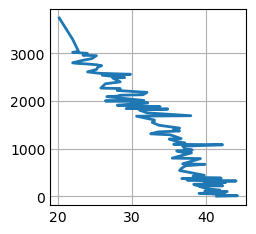

In [77]:
# plot
plt.style.use('_mpl-gallery')

fig, ax = plt.subplots()

ax.plot(result99['valordia'], result99['Altitude_range'], linewidth=2.0)

plt.show()

In [ ]:
Altit = pd.read_table('EMA_Altit.txt', sep=';')
Altit

In [69]:
Altit.to_excel('Altit.xlsx')

## Unir coords, freq, Ent con alturas y regiones

In [2]:
freqInstData = pd.read_csv('EMAHR_LatLonEntFreq2.csv', encoding='latin-1')

In [26]:
freqInstData['entidad'].unique()

array(['CENTRO NACIONAL DE INVESTIGACIONES DE CAFE', 'IDEAM', 'INVEMAR',
       'INSTITUTO DE INVESTIGACIONES MARINAS Y COSTERAS JOSE BENITO VIVES DE ANDREIS',
       'CAR - CORPORACION AUTONOMA REGIONAL DE CUNDINAMARCA',
       'FONDO DE PREVENCION Y ATENCION DE DESASTRES DE BOGOTA DC - FOPAE',
       'ESTACIONES PARTICULARES',
       'EMPRESA DE ACUEDUCTO Y ALCANTARILLADO DE BOGOTA E.S.P',
       'ISAGEN  S.A. E.S.P', 'CORPORACION REGIONAL DEL QUINDIO',
       'INSTITUTO DISTRITAL DE GESTIÓN DE RIESGOS Y CAMBIO CLIMÁTICO'],
      dtype=object)

In [22]:
AltRegs= pd.read_table('EMAHR_GeoInfo_Replaceable.txt', encoding='latin-1', sep=';')

In [4]:
freqInstData.head(2)

,Unnamed: 0,Station,lat,long,entidad,FreqInf
0,0,11025501,5.888719,-76.145167,CENTRO NACIONAL DE INVESTIGACIONES DE CAFE,5T
1,1,11030010,5.380000,-76.610000,IDEAM,H


In [23]:
AltRegs['RegsNat'].unique()

array(['Andina', 'PacÃ\xadfico', 'Caribe', 'OrinoquÃ\xada',
       'AmazonÃ\xada', 'Insular'], dtype=object)

In [19]:
AltRegs.head(3)

,OBJECTID,F1,Station,lat,long_,entidad,RASTERVALU,RegsNat
0,1,0,11025501,5.888719,-76.145167,CENTRO NACIONAL DE INVESTIGACIONES DE CAFE,1649,Andina
1,2,1,11030010,5.380000,-76.610000,IDEAM,92,Pacífico
2,3,2,11035030,5.284828,-76.627822,IDEAM,102,Pacífico


In [20]:
dfMoreInfo = pd.merge(freqInstData, AltRegs[['Station','RASTERVALU','RegsNat']], on='Station', how='left')
dfMoreInfo.head(2)

,Unnamed: 0,Station,lat,long,entidad,FreqInf,RASTERVALU,RegsNat
0,0,11025501,5.888719,-76.145167,CENTRO NACIONAL DE INVESTIGACIONES DE CAFE,5T,1649.0,Andina
1,1,11030010,5.380000,-76.610000,IDEAM,H,92.0,Pacífico


In [27]:
dfMoreInfo.to_csv('EMAHR_Allinfo_Replcbl.csv', index=False,encoding='latin-1')

## Cálculo límites "estacionales" horarios - mensuales

In [11]:
ejemplo_p2 = pd.read_csv('Pruebas_PreValid3/Estacion_0021205710_paresultado.csv', encoding='latin-1')
ejemplo_p2

,Unnamed: 0,Station,Name,Sensor,Fecha,Valor,Estado
0,74994,21205710,JARDIN BOTANICO,255,2017-10-09 15:00:00,750.5,0PSO0
1,74995,21205710,JARDIN BOTANICO,255,2017-10-09 16:00:00,750.9,0PSO0
2,74996,21205710,JARDIN BOTANICO,255,2017-10-09 17:00:00,751.5,0PSO0
3,74997,21205710,JARDIN BOTANICO,255,2017-10-09 18:00:00,752.0,0PSO0
4,74998,21205710,JARDIN BOTANICO,255,2017-10-09 19:00:00,752.2,0PSO0
...,...,...,...,...,...,...,...
50038,148318,21205710,JARDIN BOTANICO,255,2023-10-22 09:00:00,754.6,0PSO0
50039,148319,21205710,JARDIN BOTANICO,255,2023-10-22 10:00:00,754.3,0PSO0
50040,148320,21205710,JARDIN BOTANICO,255,2023-10-22 11:00:00,753.4,0PSO0
50041,148321,21205710,JARDIN BOTANICO,255,2023-10-22 12:00:00,752.5,0PSO0


In [9]:
ejemplo['Fecha'] = pd.to_datetime(ejemplo['Fecha'], format='%Y-%m-%d %H:%M:%S')

In [48]:
ejemplo.set_index('Fecha',inplace=True)

In [5]:
Horas = ejemplo['Valor'].groupby(by =[ejemplo["Fecha"].dt.month, ejemplo["Fecha"].dt.hour]).mean()#, df["Fecha_Auto"].dt.month]).sum()
Horas

Fecha  Fecha
1      0        752.782184
       1        752.264943
       2        751.719540
       3        751.437931
       4        751.466092
                   ...    
12     19       751.481871
       20       752.240936
       21       752.782353
       22       752.990643
       23       752.875294
Name: Valor, Length: 288, dtype: float64

<Axes: xlabel='Fecha,Fecha'>

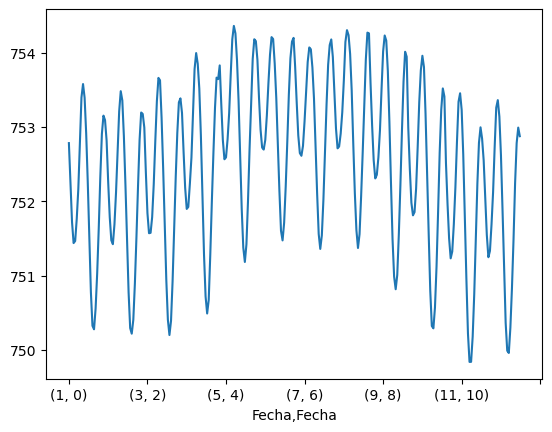

In [6]:
%matplotlib inline
Horas.plot()

In [7]:
Horas.to_excel('horas_21205710.xlsx')

In [9]:
insumos = pd.read_csv('EMA_Patm_TMaxMin.txt', sep=';')
insumos.head(2)

,OBJECTID,Station,lat,long_,nombre,sede,id_rule,codigo,Instituc,FreqInf,Altitud,TmaxNorm,TminNorm
0,1,11030010.0,5.375,-76.613,Valle,09 - Cali,9,9,IDEAM,H,58,27.853392,19.794912
1,2,11035030.0,5.285,-76.628,Valle,09 - Cali,9,9,IDEAM,H,104,27.376471,19.418962


In [10]:
alts = insumos.sort_values(by='Altitud')
alts

,OBJECTID,Station,lat,long_,nombre,sede,id_rule,codigo,Instituc,FreqInf,Altitud,TmaxNorm,TminNorm
26,27,1.501505e+07,11.128000,-74.229000,Magdalena,05 - Santa Marta,5,5,IDEAM,H,0,32.364094,24.403194
322,323,5.407721e+07,3.925147,-77.349006,Valle,09 - Cali,9,9,IDEAM,H,0,28.794662,17.974741
326,327,5.601504e+07,7.104000,-77.764000,Antioquia,01 - Medellin,1,1,IDEAM,H,0,28.504642,20.540693
299,300,5.103502e+07,1.819167,-78.730000,Nariño,07 - Pasto,7,7,IDEAM,H,0,20.764076,11.201491
327,328,5.601901e+07,6.269000,-77.433000,Antioquia,01 - Medellin,1,1,IDEAM,H,0,27.867830,21.913023
...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,345,2.120500e+09,4.950000,-75.350000,Tolima,10 - Ibague,10,10,IDEAM,Insuf,4104,22.982580,17.516573
265,266,3.509513e+07,6.362000,-72.282000,Boyaca,06 - Duitama,6,6,IDEAM,H,4355,16.199604,5.493690
112,113,2.121515e+07,4.670778,-75.327778,Tolima,10 - Ibague,10,10,IDEAM,H,4483,23.832876,19.035334
176,177,2.403538e+07,6.509111,-72.314167,Boyaca,06 - Duitama,6,6,IDEAM,H,4670,18.061207,7.000472


In [36]:
insumos[(insumos['Altitud'] > 580) & (insumos['Altitud'] < 620)]
#insumos[(insumos['Altitud'] == 300)]
#print(insumos[(insumos['OBJECTID'] == 389) ]['Station'])

,OBJECTID,Station,lat,long_,nombre,sede,id_rule,codigo,Instituc,FreqInf,Altitud,TmaxNorm,TminNorm
58,59,2.110505e+07,2.60300,-75.418000,Huila - Neiva,04 - Neiva,4,4,IDEAM,H,591,29.330202,18.500870
68,69,2.118508e+07,4.21600,-75.105000,Tolima,10 - Ibague,10,10,IDEAM,H,584,31.937704,20.861799
127,128,2.302504e+07,5.28600,-74.903000,Tolima,10 - Ibague,10,10,IDEAM,H,586,28.499201,20.216286
345,346,2.120700e+09,4.63825,-74.520028,Bogota,11 - Bogota,11,11,IDEAM,Insuf,614,29.517780,17.888041


In [2]:
ejemplo_pall = pd.read_csv('Pruebas_PreValid3/Estacion_0021195170_paresultado.csv', encoding='latin-1') #_paresultado
ejemplo_pall

,Unnamed: 0,Station,Name,Sensor,Fecha,Valor,Estado,Estado_Anterior
0,60008,21195170,PAQUILO,255,2005-07-12 11:00:00,753.3,0PER0,NaN
1,60009,21195170,PAQUILO,255,2005-07-12 12:00:00,752.9,0PER0,NaN
2,60010,21195170,PAQUILO,255,2005-07-12 13:00:00,752.1,0PER0,NaN
3,60011,21195170,PAQUILO,255,2005-07-12 14:00:00,751.7,0PER0,NaN
4,60012,21195170,PAQUILO,255,2005-07-12 16:00:00,750.6,0PER0,NaN
...,...,...,...,...,...,...,...,...
133979,355186,21195170,PAQUILO,255,2023-03-17 00:00:00,719.8,0PAT0,NaN
133980,355187,21195170,PAQUILO,255,2023-03-17 01:00:00,719.4,0PAT0,NaN
133981,355188,21195170,PAQUILO,255,2023-03-17 02:00:00,718.6,NaN,NaN
133982,355189,21195170,PAQUILO,255,2023-03-17 03:00:00,718.5,NaN,NaN


In [3]:
ejemplo_pall['Fecha'] = pd.to_datetime(ejemplo_pall['Fecha'], format='%Y-%m-%d %H:%M:%S')

In [14]:
filt = ejemplo_pall.iloc[54:72879]

In [4]:
ejemplo_pall = ejemplo_pall[~ejemplo_pall['Estado'].apply(lambda x: any([str(x).startswith(prefix) for prefix in ['0PSO0','0PAT','0PER']]))]
ejemplo_pall

,Unnamed: 0,Station,Name,Sensor,Fecha,Valor,Estado,Estado_Anterior
76,60084,21195170,PAQUILO,255,2005-07-24 14:00:00,718.6,NaN,NaN
77,60085,21195170,PAQUILO,255,2005-07-24 15:00:00,718.0,NaN,NaN
78,60086,21195170,PAQUILO,255,2005-07-24 16:00:00,717.8,NaN,NaN
79,60087,21195170,PAQUILO,255,2005-07-24 17:00:00,717.9,NaN,NaN
80,60088,21195170,PAQUILO,255,2005-07-24 18:00:00,718.0,NaN,NaN
...,...,...,...,...,...,...,...,...
133972,355179,21195170,PAQUILO,255,2023-03-16 17:00:00,718.2,NaN,NaN
133973,355180,21195170,PAQUILO,255,2023-03-16 18:00:00,718.6,NaN,NaN
133981,355188,21195170,PAQUILO,255,2023-03-17 02:00:00,718.6,NaN,NaN
133982,355189,21195170,PAQUILO,255,2023-03-17 03:00:00,718.5,NaN,NaN


In [14]:
Horas_pall = ejemplo_pall['Valor'].groupby(by =[ejemplo_pall["Fecha"].dt.month, ejemplo_pall["Fecha"].dt.hour]).mean().unstack(level=0)#, df["Fecha_Auto"].dt.month]).sum()
Horas_pall

Fecha,1,2,3,4,5,6,7,8,9,10,11,12
Fecha,,,,,,,,,,,,
0,711.961779,712.214921,712.353116,712.426367,712.360635,712.622910,712.609275,712.606916,712.660417,712.493639,712.282097,712.250350
1,711.858352,712.168689,712.471200,712.346608,712.025382,712.338988,712.239943,712.314835,712.582016,712.442890,712.165421,712.049241
2,711.708368,712.014840,712.332759,712.207459,711.828446,712.123851,711.937190,712.082493,712.622250,712.293333,711.960356,711.786250
3,711.557377,711.894027,712.306699,712.003022,711.841690,712.054902,711.862667,711.978663,712.411663,712.138901,711.851461,711.664124
4,711.494021,711.862192,712.240048,712.045082,711.760563,712.005000,711.837135,711.919023,712.518919,712.204772,711.839189,711.619713
5,711.638958,712.028668,712.360345,712.165659,711.756358,712.077183,711.926772,711.999219,712.485825,712.334228,712.052546,711.802079
6,711.740570,712.129647,712.451554,712.310086,711.748048,712.133430,712.020981,712.030851,712.538919,712.353846,712.215385,712.023679
7,711.733105,712.114214,712.296620,711.835423,711.474143,711.804819,711.897765,711.936842,712.394302,712.029921,711.800252,711.837246
8,712.096394,712.213978,712.054938,712.251299,712.020192,712.150799,712.256160,712.177326,712.749693,712.282548,712.192683,712.139759


In [7]:
Horas_pall.to_excel('Pruebas_PreValid3/plimpsic_21195170.xlsx')

In [33]:
# Crear un archivo Excel y agregar los datos
wb = Workbook()
ws = wb.active
ws.title = "Datos"

# Agregar datos al archivo Excel
for r in dataframe_to_rows(Horas_pall.reset_index(), index=False, header=True):
    ws.append(r)

# Crear la gráfica de dispersión
chart = ScatterChart()
chart.title = "Valores Promedio por Hora y Mes"
chart.style = 13
chart.x_axis.title = 'Hora del día'
chart.y_axis.title = 'Valor'

# Aumentar el tamaño del gráfico
chart.width = 20  # Anchura del gráfico (pulgadas)
chart.height = 12  # Altura del gráfico (pulgadas)

# Fijar el máximo valor del eje x
chart.x_axis.scaling.max = 24
chart.x_axis.scaling.min = 0
chart.x_axis.majorUnit = 2

# Agregar series a la gráfica
colors = ['1F77B4', 'FF7F0E', '2CA02C', 'D62728', '9467BD', '8C564B', 'E377C2', '7F7F7F', 'BCBD22', '17BECF', 'AEC7E8', 'FFBB78']
for i in range(2, 14):  # Columnas B a M (meses 1 a 12)
    xvalues = Reference(ws, min_col=1, min_row=1, max_row=25)
    yvalues = Reference(ws, min_col=i, min_row=1, max_row=25)
    series.graphicalProperties.line.solidFill = colors[i % len(colors)]  # Asignar colores a las líneas
    series.graphicalProperties.line.width = 30000  # Ajustar el grosor de las líneas
    series.marker.symbol = 'circle'  # Cambiar el marcador a círculo
    series.marker.size = 5
    series = Series(yvalues, xvalues, title_from_data=True)
    chart.series.append(series)

# Insertar la gráfica en la hoja de cálculo
ws.add_chart(chart, "O2")

# Guardar el archivo Excel
wb.save('grafica_promedio_scatter.xlsx')

In [4]:
def calc_hmMa_patm(carpeta, chunk_size=540000):
    archivos = os.listdir(carpeta)

    # Se recorre cada archivo en la carpeta
    for archivo in archivos:
        if archivo.endswith('.csv'):
            ruta_archivo = os.path.join(carpeta, archivo)
        
            # Se procesan los archivos csv por fragmentos
            reader = pd.read_csv(ruta_archivo, encoding='latin-1', chunksize=chunk_size)
            
            for chunk in reader:
                # Se generan dataframes analizados
                # De cada chunk se transforma a datetime la serie/columna 'Fecha'
                try:
                    chunk['Fecha'] = pd.to_datetime(chunk['Fecha'], format='%Y-%m-%d %H:%M:%S.%f')
                except ValueError:
                    chunk['Fecha'] = pd.to_datetime(chunk['Fecha'], format='%Y-%m-%d %H:%M:%S')
                    chunk = chunk[~chunk['Estado'].apply(lambda x: any([str(x).startswith(prefix) for prefix in ['0PSO0','0PAT','0PER']]))]

                # Se hace la agrupación para cálculo de medias horarias mensuales multianuales
                hym_ma = chunk['Valor'].groupby(by =[chunk["Fecha"].dt.month, chunk["Fecha"].dt.hour]).mean().unstack(level=0)

                # Crear un archivo Excel y agregar los datos
                wb = Workbook()
                ws = wb.active
                ws.title = "Datos"
                
                # Agregar datos al archivo Excel
                for r in dataframe_to_rows(hym_ma.reset_index(), index=False, header=True):
                    ws.append(r)
                
                # Crear la gráfica de dispersión
                chart = ScatterChart()
                chart.title = "Valores Promedio por Hora y Mes"
                chart.style = 13
                chart.x_axis.title = 'Hora del día'
                chart.y_axis.title = 'Valor'
                
                # Aumentar el tamaño del gráfico
                chart.width = 20  # Anchura del gráfico (pulgadas)
                chart.height = 12  # Altura del gráfico (pulgadas)
                
                # Fijar el máximo valor del eje x
                chart.x_axis.scaling.max = 23
                chart.x_axis.scaling.min = 0
                chart.x_axis.majorUnit = 1
                
                # Agregar series a la gráfica
                colors = ['1F77B4', 'FF7F0E', '2CA02C', 'D62728', '9467BD', '8C564B', 'E377C2', '7F7F7F', 'BCBD22', '17BECF', 'AEC7E8', 'FFBB78']
                for i in range(2, 14):  # Columnas B a M (meses 1 a 12)
                    xvalues = Reference(ws, min_col=1, min_row=2, max_row=25)
                    yvalues = Reference(ws, min_col=i, min_row=1, max_row=25)
                    series = Series(yvalues, xvalues, title_from_data=True)
                    series.graphicalProperties.line.solidFill = colors[i % len(colors)]  # Asignar colores a las líneas
                    series.graphicalProperties.line.width = 30000  # Ajustar el grosor de las líneas
                    series.marker.symbol = 'circle'  # Cambiar el marcador a círculo
                    series.marker.size = 5
                    series.marker.graphicalProperties.solidFill = colors[i % len(colors)]  # Cambiar el color del marcador
                    chart.series.append(series)
                
                # Insertar la gráfica en la hoja de cálculo
                ws.add_chart(chart, "O2")

                # Nombres archivos
                nombre_archivo_salida = os.path.join(carpeta, archivo[:19] + '_hm_ma.xlsx') #archivo[:22] el de qc
                # Guardar el archivo Excel
                wb.save(nombre_archivo_salida)

In [5]:
calc_hmMa_patm('Test_QC')

## Resultados pruebas de persistencias

Se genera un solo archivo que reuna todas las persistencias calculadas

In [13]:
# Se lee carpeta actual
carpeta = os.getcwd()
# Lista los archivos en la carpeta
archivos = os.listdir(carpeta)
dataframes = []

# Procesa los archivos que comienzan con 'cant_persist_'
for archivo in archivos:
    if archivo.startswith('cant_persist_'):
        ruta_archivo = os.path.join(carpeta, archivo)
        
        # Lee el archivo CSV
        df = pd.read_csv(ruta_archivo, encoding='latin-1')
        df = df.drop(columns='Unnamed: 0', errors='ignore')  # Elimina la columna si existe
        
        # Renombra la columna 'Cantidad_0PER0' para incluir el nombre del archivo
        nomb_archivo = archivo[13:15]
        df = df.rename(columns={'Cantidad_0PER0': f'nshifts_{nomb_archivo}'})
        
        # Añade el DataFrame a la lista
        dataframes.append(df)

# Realiza el merge de todos los DataFrames basados en la columna 'Archivo'
# El primer DataFrame será la base para hacer el merge
df1 = dataframes[0]

for df in dataframes[1:]:
    # Para evitar columnas duplicadas, utiliza how='outer'
    merged_df_q = pd.merge(df1, df, on='Archivo', how='outer')
    df1 = merged_df_q

# Revisar df resultante
orden_olumnas = ['Archivo','nshifts_3_','nshifts_4_','nshifts_5_','nshifts_6_','nshifts_7_',
                 'nshifts_8_','nshifts_9_','nshifts_10','nshifts_11','nshifts_12','nshifts_13']
merged_df_q = merged_df_q.reindex(columns=orden_olumnas)
print(merged_df_q.head(2))
merged_df_q.to_csv('cant_persist_allshifts.csv', encoding='latin-1')

                      Archivo  nshifts_3_  nshifts_4_  nshifts_5_  nshifts_6_  \
0  Estacion_0011025501_qc.csv        4694        3100        2196        1657   
1  Estacion_0011030010_qc.csv       11968       10225        8502        6831   

   nshifts_7_  nshifts_8_  nshifts_9_  nshifts_10  nshifts_11  nshifts_12  \
0        1314        1089         916         778         674         594   
1        5232        3786        2616        1777        1221         868   

   nshifts_13  
0         528  
1         652  


Unir resultado tabla de persistencias con la que posee frecuencias

In [4]:
freqsEntInfo = pd.read_csv('EMAHR_Allinfo_Replcbl.csv', sep=';', encoding='latin-1')
freqsEntInfo

,Unnamed: 0,Station,lat,long,entidad,FreqInf,Observ,RASTERVALU,RegsNat
0,0,11025501,5.888719,-76.145167,CENICAFE,5T,NaN,1649.0,Andina
1,1,11030010,5.380000,-76.610000,IDEAM,H,NaN,92.0,Pacífico
2,2,11035030,5.284828,-76.627822,IDEAM,H,NaN,102.0,Pacífico
3,3,11045010,5.690556,-76.643778,IDEAM,H,NaN,53.0,Pacífico
4,4,11050020,5.994722,-76.780028,IDEAM,H,NaN,25.0,Pacífico
...,...,...,...,...,...,...,...,...,...
615,615,5205500123,1.054806,-77.270250,IDEAM,H,NaN,2966.0,Andina
616,616,5311500056,3.848308,-76.987017,IDEAM,H,NaN,27.0,Pacífico
617,617,5311500121,3.645194,-76.564750,IDEAM,H,NaN,1637.0,Andina
618,618,5311500147,3.890083,-77.070331,IDEAM,NaN,NaN,6.0,Pacífico


In [5]:
PersistInfo = pd.read_csv('cant_persist_allshifts.csv', encoding='latin-1', sep=';')
PersistInfo

,Unnamed: 0,Archivo,nshifts_3_,nshifts_4_,nshifts_5_,nshifts_6_,nshifts_7_,nshifts_8_,nshifts_9_,nshifts_10,nshifts_11,nshifts_12,nshifts_13
0,0,11025501,4694,3100,2196,1657,1314,1089,916,778,674,594,528
1,1,11030010,11968,10225,8502,6831,5232,3786,2616,1777,1221,868,652
2,2,11035030,4895,4197,3518,2871,2276,1746,1298,938,675,494,387
3,3,11045010,5870,4373,3014,2014,1294,808,482,279,178,119,90
4,4,11050020,4674,3878,3099,2371,1711,1167,759,501,346,262,214
...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,615,5205500123,980,560,244,100,39,11,2,0,0,0,0
616,616,5311500056,6673,5300,3951,2761,1795,1095,640,373,216,138,100
617,617,5311500121,4956,3515,2316,1425,805,428,216,121,70,45,34
618,618,5311500147,0,0,0,0,0,0,0,0,0,0,0


In [6]:
PersistInfo.rename(columns={'Archivo':'Station'},inplace=True)
PersistInfo.head(2)

,Unnamed: 0,Station,nshifts_3_,nshifts_4_,nshifts_5_,nshifts_6_,nshifts_7_,nshifts_8_,nshifts_9_,nshifts_10,nshifts_11,nshifts_12,nshifts_13
0,0,11025501,4694,3100,2196,1657,1314,1089,916,778,674,594,528
1,1,11030010,11968,10225,8502,6831,5232,3786,2616,1777,1221,868,652


In [7]:
persisFreqs = pd.merge(PersistInfo, freqsEntInfo[['Station','FreqInf']], on='Station')
persisFreqs

,Unnamed: 0,Station,nshifts_3_,nshifts_4_,nshifts_5_,nshifts_6_,nshifts_7_,nshifts_8_,nshifts_9_,nshifts_10,nshifts_11,nshifts_12,nshifts_13,FreqInf
0,0,11025501,4694,3100,2196,1657,1314,1089,916,778,674,594,528,5T
1,1,11030010,11968,10225,8502,6831,5232,3786,2616,1777,1221,868,652,H
2,2,11035030,4895,4197,3518,2871,2276,1746,1298,938,675,494,387,H
3,3,11045010,5870,4373,3014,2014,1294,808,482,279,178,119,90,H
4,4,11050020,4674,3878,3099,2371,1711,1167,759,501,346,262,214,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,615,5205500123,980,560,244,100,39,11,2,0,0,0,0,H
616,616,5311500056,6673,5300,3951,2761,1795,1095,640,373,216,138,100,H
617,617,5311500121,4956,3515,2316,1425,805,428,216,121,70,45,34,H
618,618,5311500147,0,0,0,0,0,0,0,0,0,0,0,NaN


In [8]:
filt1 = persisFreqs[(persisFreqs['FreqInf'] == 'H')] #& (persisFreqs['nshifts_13'])]

In [9]:
filt1

,Unnamed: 0,Station,nshifts_3_,nshifts_4_,nshifts_5_,nshifts_6_,nshifts_7_,nshifts_8_,nshifts_9_,nshifts_10,nshifts_11,nshifts_12,nshifts_13,FreqInf
1,1,11030010,11968,10225,8502,6831,5232,3786,2616,1777,1221,868,652,H
2,2,11035030,4895,4197,3518,2871,2276,1746,1298,938,675,494,387,H
3,3,11045010,5870,4373,3014,2014,1294,808,482,279,178,119,90,H
4,4,11050020,4674,3878,3099,2371,1711,1167,759,501,346,262,214,H
5,5,11080010,5801,4499,3274,2250,1424,852,487,276,159,97,71,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,613,5102500128,13116,11605,10125,8674,7248,5856,4574,3503,2630,1950,1469,H
614,614,5202500132,951,699,523,391,285,205,144,101,67,47,35,H
615,615,5205500123,980,560,244,100,39,11,2,0,0,0,0,H
616,616,5311500056,6673,5300,3951,2761,1795,1095,640,373,216,138,100,H


In [10]:
filt1['nshifts_13'].value_counts().count()

242

In [11]:
filt1['nshifts_13'].sort_values(ascending=False).ravel()

array([37735, 34889, 32212, 23834, 21667, 21602, 20171, 19967, 18801,
       18555, 18427, 17987, 17953, 17334, 16926, 16920, 16193, 16133,
       15806, 14059, 13798, 13686, 12896, 12657, 11961, 11557, 11349,
       11119, 10999, 10868, 10413,  9989,  8936,  8463,  8303,  8154,
        7828,  7799,  7783,  7737,  7625,  7584,  7473,  7120,  6862,
        6852,  6760,  6709,  6641,  6499,  6367,  6138,  6127,  6067,
        6017,  5844,  5643,  5524,  5454,  5405,  5308,  5292,  5165,
        5093,  4983,  4861,  4817,  4740,  4632,  4608,  4394,  4347,
        4299,  4238,  4135,  4073,  3988,  3965,  3861,  3761,  3733,
        3603,  3503,  3462,  3228,  3059,  2967,  2720,  2606,  2558,
        2274,  2261,  2242,  2181,  2117,  2111,  2067,  2021,  1937,
        1916,  1833,  1817,  1778,  1732,  1717,  1716,  1712,  1670,
        1641,  1641,  1594,  1554,  1539,  1533,  1518,  1469,  1332,
        1289,  1276,  1234,  1223,  1202,  1167,  1140,  1120,  1043,
        1000,   997,

In [12]:
filt1['nshifts_13'].sort_values(ascending=False)

490    37735
55     34889
470    32212
311    23834
357    21667
       ...  
450        0
147        0
454        0
146        0
103        0
Name: nshifts_13, Length: 449, dtype: int64

In [13]:
persisFreqs.iloc[357]

Unnamed: 0         357
Station       26157170
nshifts_3_       33767
nshifts_4_       31756
nshifts_5_       30068
nshifts_6_       28596
nshifts_7_       27277
nshifts_8_       26073
nshifts_9_       24997
nshifts_10       24047
nshifts_11       23178
nshifts_12       22384
nshifts_13       21667
FreqInf              H
Name: 357, dtype: object

In [16]:
filt1[filt1['nshifts_13'] == 13]

,Unnamed: 0,Station,nshifts_3_,nshifts_4_,nshifts_5_,nshifts_6_,nshifts_7_,nshifts_8_,nshifts_9_,nshifts_10,nshifts_11,nshifts_12,nshifts_13,FreqInf
208,208,23065505,1167,687,389,212,126,76,51,36,27,19,13,H
612,612,3706500109,1722,1091,692,440,278,179,108,65,39,24,13,H


In [18]:
precipECM_R = pd.read_csv(r'C:\Users\user\Documents\IDEAM\2023\Obligaciones_Especificas\OE_2_ImplemCriteriosValidacion_EstAutom_Umbrales\DatosEMA_Crudos_Precip\1series_prpc_day_raw_melted.csv')

In [19]:
precipECM_R.head(2)

,Unnamed: 0,fecha,Station,Rainfall
0,0,1981-01-01,11010010,0.0
1,1,1981-01-02,11010010,0.0


In [39]:
filtfechas = precipECM_R[(precipECM_R['Station']==37055010)] #& (precipECM_R['fecha']=='2019-01')] # Se cambia para pruebas

In [40]:
filtfechas.set_index('fecha', inplace=True)
filtfechas

,Unnamed: 0,Station,Rainfall
fecha,,,
1981-01-01,18393990,37055010,0.0
1981-01-02,18393991,37055010,0.0
1981-01-03,18393992,37055010,0.0
1981-01-04,18393993,37055010,0.0
1981-01-05,18393994,37055010,0.0
...,...,...,...
2020-12-27,18408595,37055010,NaN
2020-12-28,18408596,37055010,NaN
2020-12-29,18408597,37055010,NaN


In [49]:
filtfechas['2018-11':'2019-02']['Rainfall'].ravel()

array([ 0. ,  0.2,  0. ,  0. ,  0. ,  0. , 13.4,  1. , 15.3,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  7.1, 16.5,  0.1,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  3.8,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. , 19.9,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ])

In [54]:
filtfechas['2018-11-01':'2018-11-09']

,Unnamed: 0,Station,Rainfall
fecha,,,
2018-11-01,18407808,37055010,0.0
2018-11-02,18407809,37055010,0.2
2018-11-03,18407810,37055010,0.0
2018-11-04,18407811,37055010,0.0
2018-11-05,18407812,37055010,0.0
2018-11-06,18407813,37055010,0.0
2018-11-07,18407814,37055010,13.4
2018-11-08,18407815,37055010,1.0
2018-11-09,18407816,37055010,15.3


------

In [75]:
filt1['nshifts_6_'].sort_values(ascending=False).ravel()

array([47875, 38329, 36582, 29657, 28965, 28596, 26544, 26106, 25528,
       25466, 23648, 21609, 21084, 19182, 19139, 19045, 18846, 18634,
       18238, 18086, 17632, 17275, 16825, 16457, 16223, 15155, 15147,
       14487, 14281, 13085, 12414, 11953, 11708, 11607, 11435, 10784,
       10715, 10668, 10511, 10102,  9980,  9906,  9778,  9473,  9461,
        9449,  9378,  9352,  9111,  9077,  8909,  8674,  8574,  8420,
        8166,  8037,  7912,  7892,  7785,  7765,  7710,  7507,  7442,
        7413,  6913,  6893,  6831,  6636,  6607,  6535,  6471,  6260,
        5987,  5884,  5643,  5628,  5574,  5556,  5502,  5487,  5366,
        5351,  5325,  5289,  5106,  5019,  4925,  4878,  4712,  4600,
        4597,  4503,  4402,  4364,  4350,  4340,  4280,  4280,  3972,
        3951,  3810,  3742,  3732,  3641,  3514,  3495,  3457,  3450,
        3284,  3271,  3218,  3076,  2992,  2952,  2916,  2871,  2857,
        2844,  2826,  2765,  2761,  2695,  2642,  2595,  2569,  2425,
        2416,  2377,

In [63]:
filt1[filt1['nshifts_3_'] == 0]

,Unnamed: 0,Station,nshifts_3_,nshifts_4_,nshifts_5_,nshifts_6_,nshifts_7_,nshifts_8_,nshifts_9_,nshifts_10,nshifts_11,nshifts_12,nshifts_13,FreqInf
11,11,11155030,0,0,150,119,94,73,55,42,32,25,19,H
71,71,21045010,0,0,0,0,0,0,0,0,0,0,0,H
82,82,21095010,0,0,0,0,0,0,0,0,0,0,0,H
88,88,21115100,0,0,0,0,0,0,0,0,0,0,0,H
178,178,21255090,0,0,0,0,0,0,0,0,0,0,0,H
192,192,23020080,0,0,0,0,0,0,0,0,0,0,0,H
250,250,24015513,0,0,0,0,0,0,0,0,0,0,0,H
365,365,26185020,0,0,0,0,0,0,0,0,0,0,0,H
402,402,29045180,0,0,0,0,0,0,0,0,0,0,0,H


----

In [87]:
filt2 = persisFreqs[(persisFreqs['FreqInf'] == '5T')]

In [88]:
filt2['nshifts_13'].sort_values(ascending=False).ravel()

array([22799, 10456,  9937,  9162,  8948,  7921,  7756,  7559,  7324,
        6585,  6326,  6188,  6088,  5959,  5949,  5899,  5598,  5491,
        4469,  4368,  4207,  4180,  3904,  3333,  3039,  3012,  2886,
        2722,  2643,  2604,  2446,  2413,  2302,  2293,  2135,  2077,
        2041,  1980,  1862,  1772,  1652,  1636,  1635,  1632,  1557,
        1472,  1326,  1298,  1270,  1181,  1156,  1109,  1103,  1089,
        1066,  1012,  1005,   970,   950,   935,   923,   919,   891,
         891,   831,   759,   722,   714,   712,   694,   681,   680,
         667,   656,   654,   607,   597,   569,   543,   531,   528,
         465,   464,   434,   423,   392,   392,   334,   330,   280,
         260,   230,   162,   136,   123,    74,    31,    30,     7,
           7,     0], dtype=int64)

In [95]:
filt2[filt2['nshifts_13'] == 423]

,Unnamed: 0,Station,nshifts_3_,nshifts_4_,nshifts_5_,nshifts_6_,nshifts_7_,nshifts_8_,nshifts_9_,nshifts_10,nshifts_11,nshifts_12,nshifts_13,FreqInf
194,194,23025501,3288,2050,1419,1075,873,731,633,559,505,460,423,5T


In [82]:
filtfechas2 = precipECM_R[(precipECM_R['Station']==23055501)]

In [84]:
filtfechas2

,Unnamed: 0,Station,Rainfall
fecha,,,


In [83]:
filtfechas2.set_index('fecha', inplace=True)
filtfechas2

,Unnamed: 0,Station,Rainfall
fecha,,,


In [ ]:
filtfechas2['2019-04':'2019-05']['Rainfall'].ravel()